In [1]:
import pickle

# Load the model from a file
with open('/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/pretrained/vitb16/modelb16.pkl', 'rb') as f:
    pretrained_vit = pickle.load(f)
    
with open('/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/pretrained/vitb16/modelb16_test.pkl', 'rb') as f:
    test_dataloader_pretrained = pickle.load(f)

with open('/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/pretrained/vitb16/modelb16_results.pkl', 'rb') as f:
    pretrained_vit_results = pickle.load(f)
    
# Load the model from a file
with open('/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/pretrained/resnet/model.pkl', 'rb') as f:
    model = pickle.load(f)
    
with open('/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/pretrained/resnet/resnet_results.pkl', 'rb') as f:
    resnet_results = pickle.load(f)

# Assuming you have a directory with test images
test_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Testing"

2024-04-29 15:40:48.987369: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 15:40:49.060532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 15:40:50.863804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


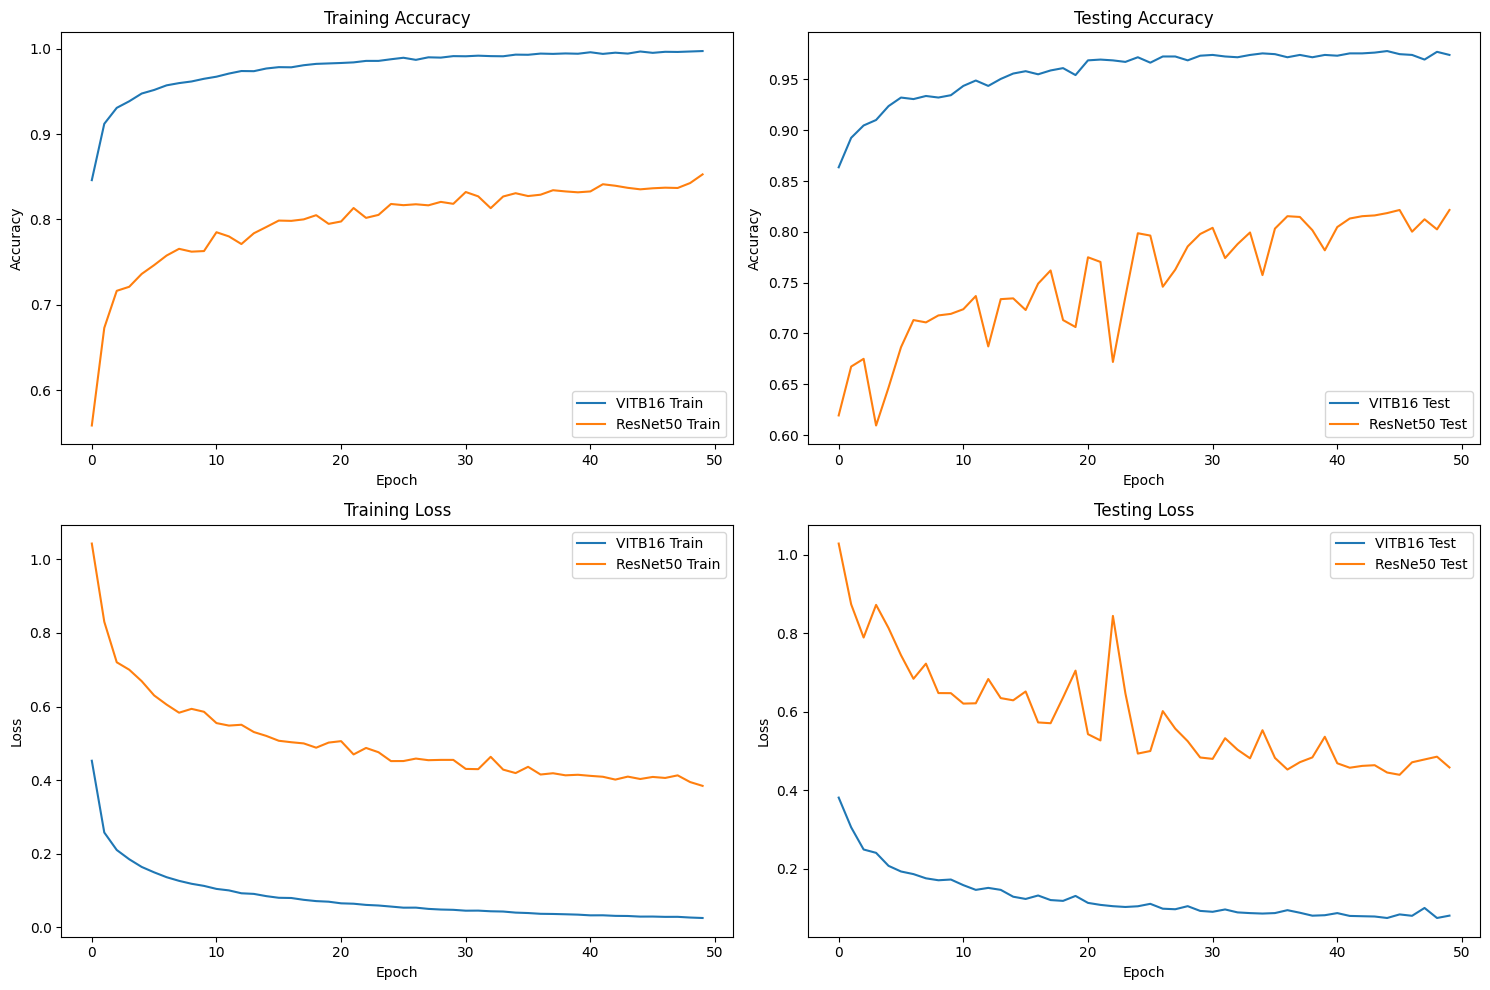

In [3]:
import matplotlib.pyplot as plt

# Extract results
vit_train_loss = pretrained_vit_results['train_loss']
vit_test_loss = pretrained_vit_results['test_loss']
vit_train_accuracy = pretrained_vit_results['train_acc']
vit_test_accuracy = pretrained_vit_results['test_acc']

resnet_train_loss = resnet_results['train_loss']
resnet_test_loss = resnet_results['test_loss']
resnet_train_accuracy = resnet_results['train_accuracy']
resnet_test_accuracy = resnet_results['test_accuracy']

# Create sub-plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Summarize history for training accuracy
axs[0, 0].plot(vit_train_accuracy, label='VITB16 Train')
axs[0, 0].plot(resnet_train_accuracy, label='ResNet50 Train')
axs[0, 0].set_title('Training Accuracy')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(loc='lower right')

# Summarize history for testing accuracy
axs[0, 1].plot(vit_test_accuracy, label='VITB16 Test')
axs[0, 1].plot(resnet_test_accuracy, label='ResNet50 Test')
axs[0, 1].set_title('Testing Accuracy')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(loc='lower right')

# Summarize history for training loss
axs[1, 0].plot(vit_train_loss, label='VITB16 Train')
axs[1, 0].plot(resnet_train_loss, label='ResNet50 Train')
axs[1, 0].set_title('Training Loss')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(loc='upper right')

# Summarize history for testing loss
axs[1, 1].plot(vit_test_loss, label='VITB16 Test')
axs[1, 1].plot(resnet_test_loss, label='ResNe50 Test')
axs[1, 1].set_title('Testing Loss')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import torch

test_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Testing"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the class names
class_names = ['glioma','meningioma', 'notumor', 'pituitary']

def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return true_labels, pred_labels

# Get true and predicted labels
true_labels, pred_labels = evaluate_model(pretrained_vit, test_dataloader_pretrained, device)

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)

# Compute the confusion matrix
vit_confusion_matrix = confusion_matrix(true_labels, pred_labels)
print("VITB16 Confusion Matrix:\n", vit_confusion_matrix)

# Compute the F1 score
vit_precision, vit_recall, vit_f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
print("VITB16 F1 Score: ", vit_f1_score)

VITB16 Confusion Matrix:
 [[276  22   1   1]
 [  4 301   0   1]
 [  0   0 405   0]
 [  0   5   0 295]]
VITB16 F1 Score:  0.9741079138136856


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support


# Set up the data generator for testing images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = test_generator.classes

# Compute the confusion matrix
resnet_confusion_matrix = confusion_matrix(y_true, y_pred_classes)
print("ResNet Confusion Matrix:\n", resnet_confusion_matrix)

# Compute the F1 score
resnet_precision, resnet_recall, resnet_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
print("ResNet F1 Score: ", resnet_f1_score)


Found 1311 images belonging to 4 classes.


/home/usd.local/sonyreddy.gurram/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 461ms/step
ResNet Confusion Matrix:
 [[182  94   4  20]
 [ 22 219  27  38]
 [  1   5 386  13]
 [  4   6   0 290]]
ResNet F1 Score:  0.8168448893743874


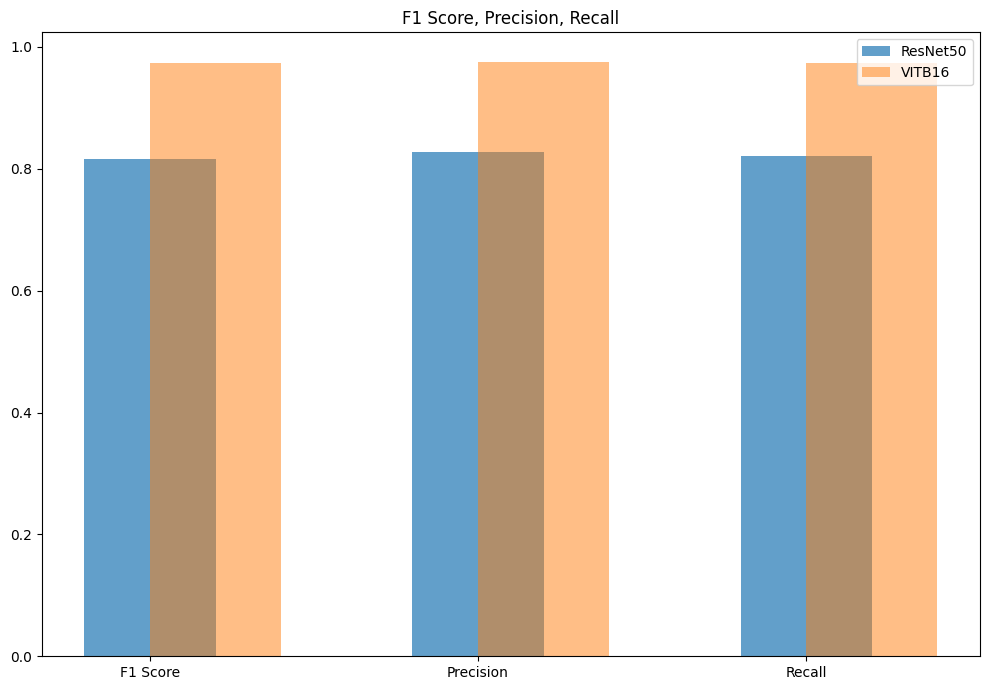

In [13]:
import matplotlib.pyplot as plt

# Create sub-plots
fig, ax = plt.subplots(figsize=(10,7))

# F1 Score, Precision, Recall
metrics = [resnet_f1_score, resnet_precision, resnet_recall]
vit_metrics = [vit_f1_score, vit_precision, vit_recall]
x_labels = ['F1 Score', 'Precision', 'Recall']

# Plotting
x = range(len(x_labels))
ax.bar(x, metrics, width=0.4, align='center', alpha=0.7, label='ResNet50')
ax.bar(x, vit_metrics, width=0.4, align='edge', alpha=0.5, label='VITB16')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_title('F1 Score, Precision, Recall')
ax.legend()

plt.tight_layout()
plt.show()

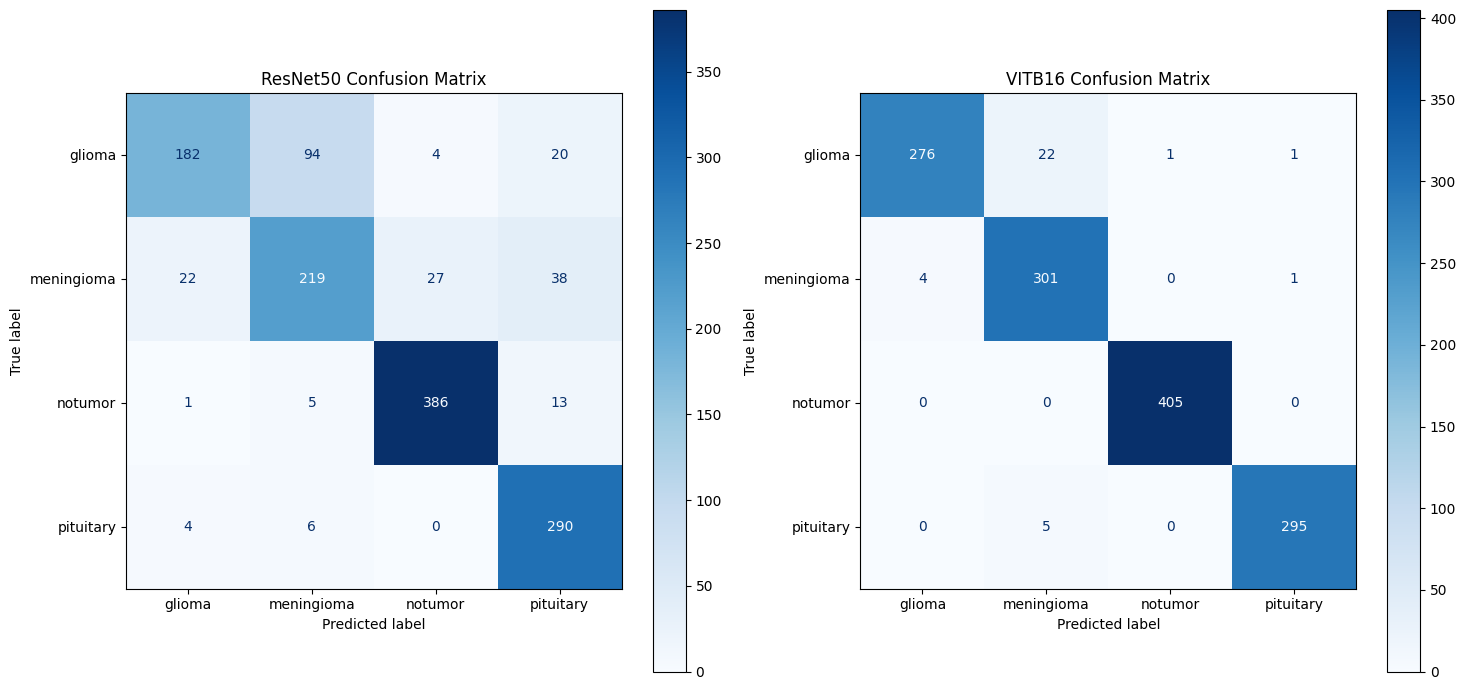

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Create sub-plots
fig, axs = plt.subplots(1, 2, figsize=(15,7))

# Confusion matrices
disp = ConfusionMatrixDisplay(confusion_matrix=resnet_confusion_matrix,
                              display_labels=test_generator.class_indices.keys())
disp.plot(cmap='Blues', ax=axs[0])
axs[0].set_title('ResNet50 Confusion Matrix')

disp = ConfusionMatrixDisplay(confusion_matrix=vit_confusion_matrix,
                              display_labels=class_names)
disp.plot(cmap='Blues', ax=axs[1])
axs[1].set_title('VITB16 Confusion Matrix')

plt.tight_layout()
plt.show()